<a href="https://colab.research.google.com/github/hamasakram/Developers-Corporation-AI-Internship/blob/main/Satellite_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up Env**

In [1]:
# Step 1: Install the kagglehub library
!pip install kagglehub

# Step 2: Authenticate with Kaggle
# Upload your Kaggle API token (kaggle.json) to Colab
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Move the kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Importing the Data**

In [2]:
# Step 3: Download the dataset
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("nikitarom/planets-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.50G/1.50G [01:14<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikitarom/planets-dataset/versions/3


In [3]:
kagglehub.dataset_download

<function kagglehub.datasets.dataset_download(handle: str, path: Optional[str] = None, *, force_download: Optional[bool] = False) -> str>

In [4]:
import os

# List files in the downloaded directory
files = os.listdir(path)
print("Files in the dataset directory:", files)

Files in the dataset directory: ['test-jpg-additional', 'planet']


In [5]:
import shutil

# Move the dataset to /content/
shutil.move(path, "/content/planets-dataset")
print("Dataset moved to /content/planets-dataset")

Dataset moved to /content/planets-dataset


In [6]:
import os

# List files in the dataset directory
dataset_path = "/content/planets-dataset"
files = os.listdir(dataset_path)
print("Files in the dataset directory:", files)

Files in the dataset directory: ['test-jpg-additional', 'planet']


In [7]:
!pip install fastai --upgrade -q
from fastai.vision.all import *
from scipy.stats import bernoulli
import warnings
warnings.filterwarnings("ignore")

!pip install wwf -q
!pip install timm -q
from wwf.vision.timm import *

!pip install efficientnet_pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [8]:
import pandas as pd
from pathlib import Path
train_df = pd.read_csv('/content/planets-dataset/planet/planet/train_classes.csv')

In [9]:
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [14]:

# Load the CSV file
train_df = pd.read_csv(path/'train_classes.csv')

# Add .jpg extension to filenames if missing
train_df['image_name'] = train_df['image_name'] + '.jpg'

# Save the updated CSV (optional)
train_df.to_csv(path/'train_classes_updated.csv', index=False)

# Display the first few rows of the updated CSV
print(train_df.head())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road


In [11]:
def get_x(r):
    return path/'train-jpg'/(r['image_name']+'.jpg')

def get_y(r):
    return r['tags'].split()

def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=get_x,
                       get_y=get_y,
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True,max_warp=0),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [12]:
import os
print(os.listdir('/content/planets-dataset/planet/planet/train-jpg'))

['train_25961.jpg', 'train_28648.jpg', 'train_2812.jpg', 'train_37650.jpg', 'train_10830.jpg', 'train_36371.jpg', 'train_12160.jpg', 'train_27633.jpg', 'train_20715.jpg', 'train_25587.jpg', 'train_26632.jpg', 'train_7828.jpg', 'train_8461.jpg', 'train_7508.jpg', 'train_14901.jpg', 'train_37074.jpg', 'train_16888.jpg', 'train_12490.jpg', 'train_24469.jpg', 'train_27825.jpg', 'train_3473.jpg', 'train_33222.jpg', 'train_29875.jpg', 'train_14267.jpg', 'train_32302.jpg', 'train_17207.jpg', 'train_4542.jpg', 'train_25438.jpg', 'train_30872.jpg', 'train_34983.jpg', 'train_18624.jpg', 'train_2266.jpg', 'train_31486.jpg', 'train_5135.jpg', 'train_19583.jpg', 'train_33435.jpg', 'train_13084.jpg', 'train_36646.jpg', 'train_22644.jpg', 'train_1003.jpg', 'train_19978.jpg', 'train_29825.jpg', 'train_21672.jpg', 'train_1685.jpg', 'train_20789.jpg', 'train_4590.jpg', 'train_15209.jpg', 'train_37471.jpg', 'train_24604.jpg', 'train_34497.jpg', 'train_19776.jpg', 'train_3025.jpg', 'train_8351.jpg', 'trai

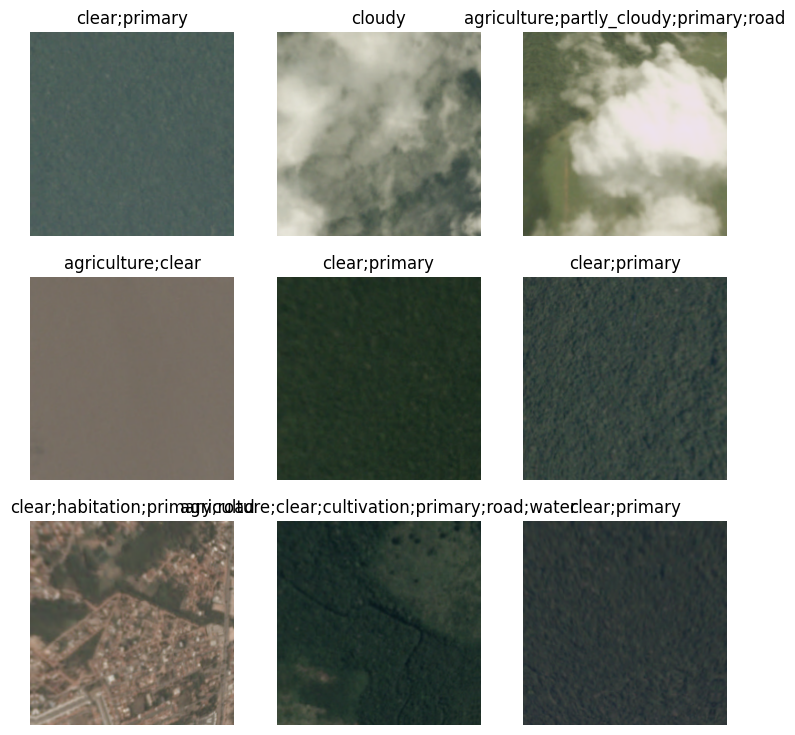

In [15]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd

# Define the path to your dataset
path = Path('/content/planets-dataset/planet/planet')

# Load the CSV file
train_df = pd.read_csv(path/'train_classes_updated.csv')

# Create DataLoaders
dls = ImageDataLoaders.from_df(
    train_df,
    path=path/'train-jpg',  # Folder containing images
    fn_col=0,               # Column with filenames
    label_col=1,            # Column with labels
    label_delim=' ',        # If labels are space-separated
    valid_pct=0.2,          # 20% of the data will be used for validation
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224)
)

# Verify the DataLoaders
dls.show_batch()

**Performing EDA**

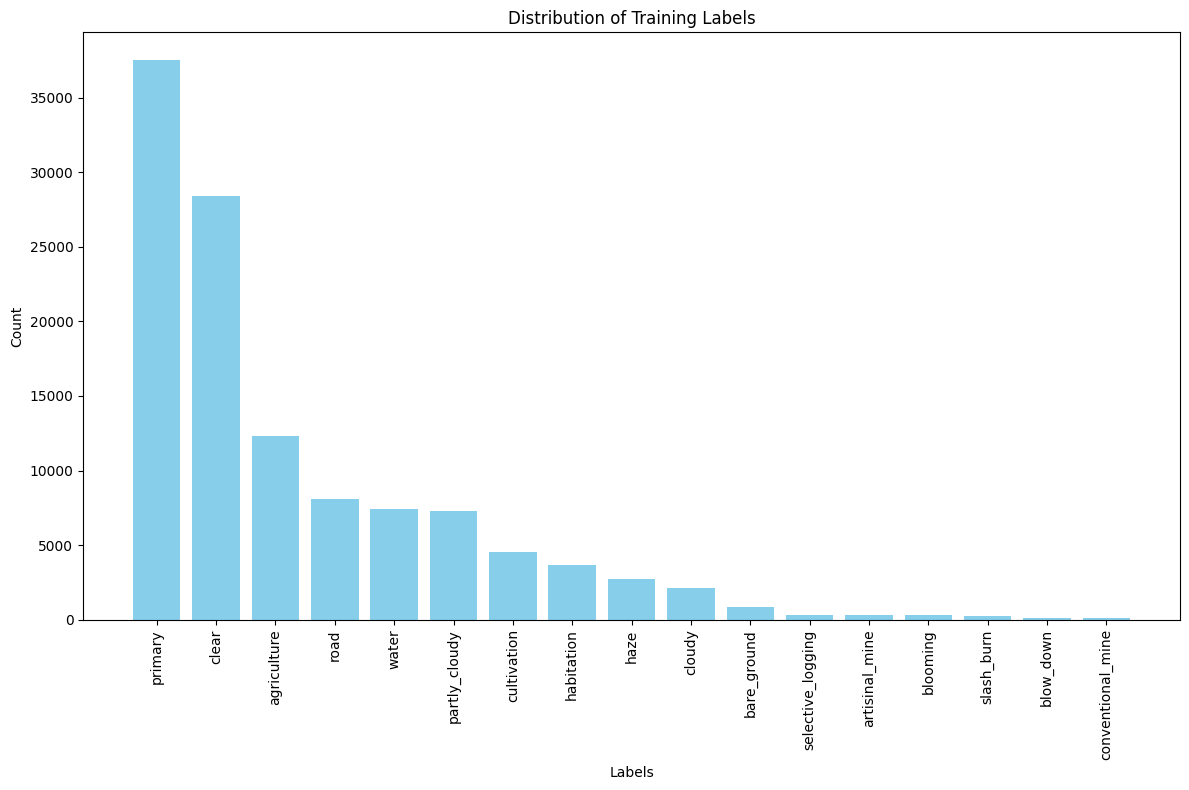

In [23]:
import matplotlib.pyplot as plt

# Process labels and count occurrences
labels = train_df['tags'].str.split(' ')
counts = labels.explode().value_counts()

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(counts.index, counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Training Labels')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

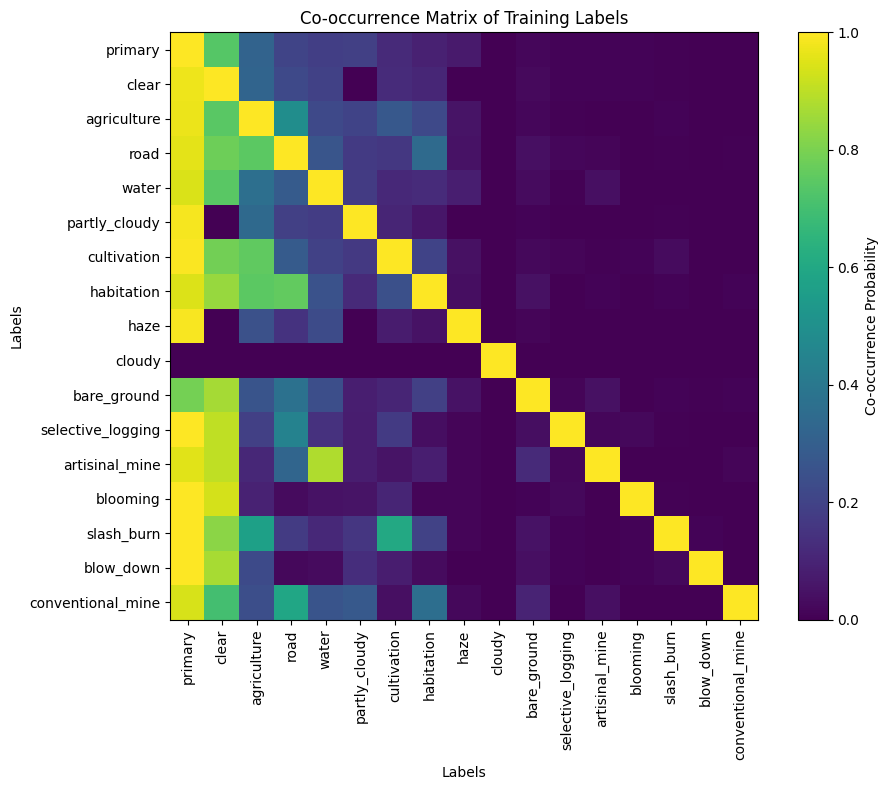

In [24]:
import numpy as np
# Create the co-occurrence matrix
com = np.zeros([len(counts)] * 2)
for i, l in enumerate(counts.keys()):
    for i2, l2 in enumerate(counts.keys()):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row:
                    cy += 1
        com[i, i2] = cy / c

# Plot the co-occurrence matrix as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(com, cmap='viridis', interpolation='nearest')

# Add labels and title
plt.xticks(np.arange(len(counts)), counts.keys(), rotation=90)
plt.yticks(np.arange(len(counts)), counts.keys())
plt.xlabel('Labels')
plt.ylabel('Labels')
plt.title('Co-occurrence Matrix of Training Labels')

# Add a colorbar
plt.colorbar(label='Co-occurrence Probability')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
all_tags = [item for sublist in list(train_df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/train_df.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [26]:
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()

,tag,0
12,primary,37513
5,clear,28431
0,agriculture,12315
13,road,8071
16,water,7411


In [27]:
sample = pd.read_csv('planets-dataset/planet/planet/sample_submission.csv')
print(sample.shape)
sample.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [28]:
tag_probas = tags_counted_and_sorted[0].values/tags_counted_and_sorted[0].values.sum()
indicators = np.hstack([bernoulli.rvs(p, 0, sample.shape[0]).reshape(sample.shape[0], 1) for p in tag_probas])
indicators = np.array(indicators)
indicators.shape

(61191, 17)

In [29]:
indicators[:10,:]


array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [30]:
sorted_tags = tags_counted_and_sorted['tag'].values
all_test_tags = []
for index in range(indicators.shape[0]):
    all_test_tags.append(' '.join(list(sorted_tags[np.where(indicators[index, :] == 1)[0]])))
len(all_test_tags)

61191

In [31]:
sample['tags'] = all_test_tags
print(sample.head())
sample.to_csv('bernoulli_submission.csv', index=False)

  image_name                 tags
0     test_0  primary agriculture
1     test_1     clear habitation
2     test_2         primary road
3     test_3                clear
4     test_4              primary


**Training**

In [32]:

f2samples = FBetaMulti(beta=2,average='samples',thresh=0.2)


metrics = [partial(accuracy_multi, thresh=0.2), f2samples]
cbs = [MixUp]

In [33]:


learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, cbs=cbs)

# learn.lr_find()

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [34]:
learn.fine_tune(5, base_lr=3e-2, freeze_epochs=2)


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.191594,0.174412,0.928424,0.879240,05:56
1,0.170778,0.124117,0.944679,0.895902,05:39


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.152982,0.110078,0.946910,0.913257,06:54
1,0.150212,0.098855,0.954642,0.916127,06:52
2,0.146013,0.093578,0.952593,0.921026,06:52
3,0.136982,0.087770,0.955165,0.925889,06:53
4,0.134428,0.088942,0.955812,0.925990,06:52


**Learning Curve**

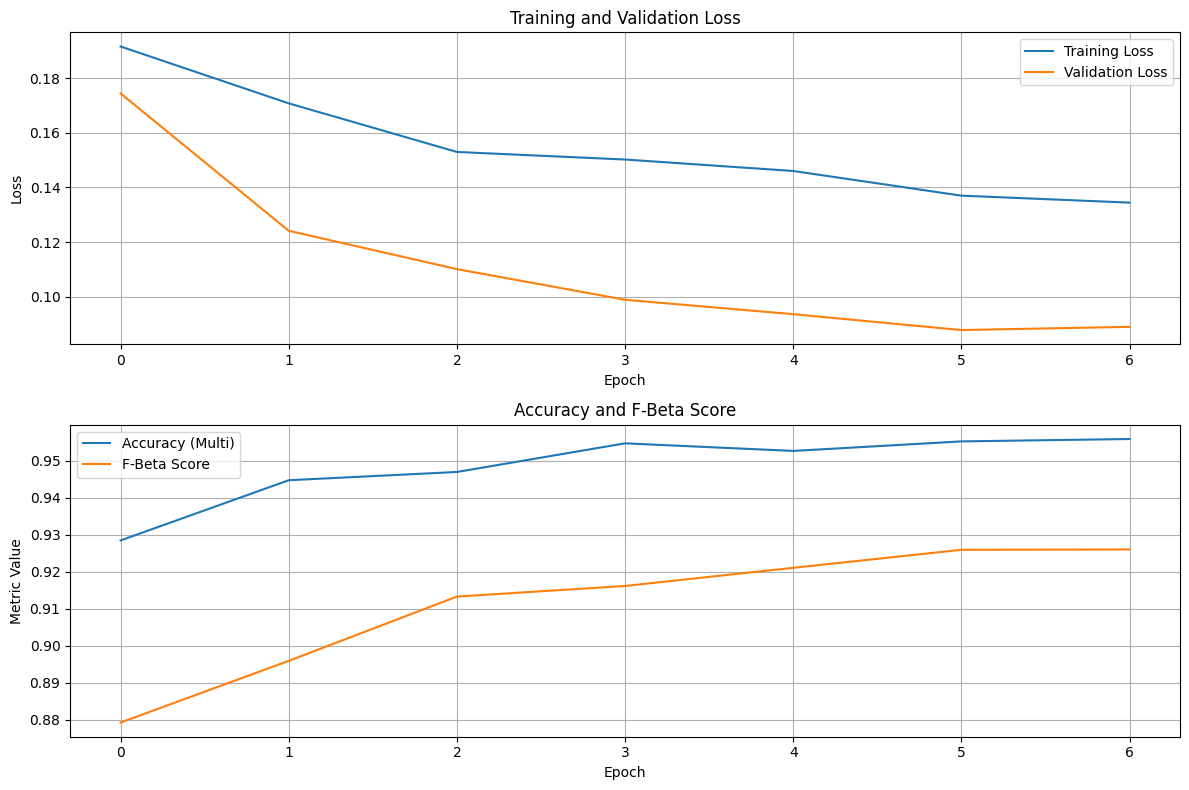

In [39]:

# Extract logged values from the training logs
epochs = list(range(7))  # Adjust to match the length of logged values (7 in this case)
train_losses = [0.191594, 0.170778, 0.152982, 0.150212, 0.146013, 0.136982, 0.134428]
valid_losses = [0.174412, 0.124117, 0.110078, 0.098855, 0.093578, 0.087770, 0.088942]
accuracy_multi = [0.928424, 0.944679, 0.946910, 0.954642, 0.952593, 0.955165, 0.955812]
fbeta_score = [0.879240, 0.895902, 0.913257, 0.916127, 0.921026, 0.925889, 0.925990]

# Plot the learning curve
plt.figure(figsize=(12, 8))

# Plot training and validation losses
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Plot accuracy and F-beta score
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy_multi, label='Accuracy (Multi)')
plt.plot(epochs, fbeta_score, label='F-Beta Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Accuracy and F-Beta Score')
plt.legend()
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [44]:
from fastai.vision.all import *
from pathlib import Path

def predict_image(image_path, learn, train_df, threshold=0.2):
    """
    Predicts the tags for an image and checks if the prediction is correct.

    Args:
        image_path (str or Path): Path to the image file.
        learn (Learner): Trained FastAI Learner object.
        train_df (pd.DataFrame): DataFrame containing the true labels.
        threshold (float): Threshold for converting probabilities to binary predictions.

    Returns:
        dict: A dictionary containing the predicted tags, true tags, and whether the prediction is correct.
    """
    # Load the image
    img = PILImage.create(image_path)

    # Get the prediction
    pred = learn.predict(img)

    # Extract probabilities (pred[1] is the tensor of probabilities)
    pred_probs = pred[1].numpy()  # Convert tensor to NumPy array

    # Get the predicted tags
    pred_tags = learn.dls.vocab[pred_probs > threshold]

    # Get the true tags from the training DataFrame
    image_name = Path(image_path).name
    true_tags = train_df[train_df['image_name'] == image_name]['tags'].values[0].split()

    # Check if the prediction is correct
    is_correct = set(pred_tags) == set(true_tags)

    return {
        'image_name': image_name,
        'predicted_tags': pred_tags,
        'true_tags': true_tags,
        'is_correct': is_correct
    }

In [46]:
# Example: Predict tags for an image
image_path = '/content/planets-dataset/planet/planet/train-jpg/train_1.jpg'
result = predict_image(image_path, learn, train_df, threshold=0.2)

# Print the results
print("Image Name:", result['image_name'])
print("Predicted Tags:", result['predicted_tags'])
print("True Tags:", result['true_tags'])
print("Is Prediction Correct?", result['is_correct'])

Image Name: train_1.jpg
Predicted Tags: ['agriculture', 'clear', 'primary', 'water']
True Tags: ['agriculture', 'clear', 'primary', 'water']
Is Prediction Correct? True
